<a href="https://colab.research.google.com/github/ericzundel/imagecapturegui/blob/main/Ayers_2024_StudentRecognition_Used_to_create_tflite_image_April_22_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a model to recognize student faces.

This notebook was originally created by Pascal Van Hentenryck and Beth White for a high school class sponsored by the AI Institute for Optimization Advances at Georgia Tech.  It has been modified to train a model that can be used on a Raspberry Pi 4.  See [Eric Ayers' github account](https://github.com/ericzundel/imagecapturegui) for code used to capture images and run the trained model under Tensorflow Lite.

In [ ]:
import os
import shutil
import pathlib
import json

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# For visualization and debugging
import matplotlib.pyplot as plt

###
# Constants used in the rest of the notebook

# Size in pixels to use for width and height of images sent to the model.
# Images saved on IMAGE_DATA_PATH should be >= than this size.
SIZE_PICTURE=100

# Path to find files to send to the model on Google Drive
IMAGE_DATA_PATH='/content/gdrive/My Drive/MLImages-backup-240416-140003'

# Path to use to save models
OUTPUT_MODEL_BASE = "/content/gdrive/My Drive/AI-Institute_Drew Collaboration/2024model/"
OUTPUT_MODEL_NAME='student_recognition_2024_32bit'

# You need to know the version of tensorflow if you want to re-import the model on another computer
# to make sure you pull in the right version of tensorflow
# This notebook originally used 2.15.0 on April 22, 2024
print("Tensorflow Version: " + tf.__version__)

Tensorflow Version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "{IMAGE_DATA_PATH}"

plt.figure(figsize=(10, 10))  # Setup the plotting library

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 Alexandra_Price      Destin_Woolf	  Justin_Leake	  "Rhyland_O'Neill"
 Armon_Anderson       Donald_Humphrey	  Kaci_Turner	  'Tahlin_Thompson Saunders-Brathwaite'
 Austin_Smith	      Don_Evans		  Kenadie_Smith    Tarrence_Sturdivant
 Beth_White	      Emma_Davis	  Kendrick_Myers   Thorn_High
 Chase_Griffin	      Eric_Ayers	  Kristine_Allen   Trinity_Smith
 Christian_Hill       Jackson_Humphries   Laila_Shannon    Tunazi_Bello
 Cordarius_Williams   Jonathan_Thompson   Landon_Cox	   Victor_Hicks
 Curtis_Augustin      Joshua_Boney	  Lucian_Leon	  'Zediwa_De Jesus'
 David_Kurt	      Julian_Carlson	  Malik_Weems
 Destin_Jack	      Justin_Brown	  Peter_McKnight


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:
def tensor_from_image(filename):
    """Convert a PIL image into a tensor datatype"""
    img = load_img(filename,color_mode = 'rgb')
    img = img.resize((SIZE_PICTURE, SIZE_PICTURE))
    # If the img_to_array() function is not available, use np.asarray() which should be safe with BGR files.
    arr = img_to_array(img)

    arr = arr.reshape((SIZE_PICTURE, SIZE_PICTURE, 3))

    # Convert the tensor datatype to 32 bits because converting the model to
    # Tensorflow Lite will force the model to use 32 bit floating math.
    arr = np.float32(arr)

    return arr

In [ ]:
def load_dataset():
    """Read in the files stored in IMAGE_DATA_PATH

    Convert  image files into tensor format suitable to send to a  Keras model.
    Divide the set into training and test tensors.

    Images are labeled by the directory name where they are found. There is
    also an  implicit assumption when recognizing faces that labels are
    people's names in {first_name}_{last_name} format.

    IMAGE_DATA_PATH/
            label 0/
                image file 1
                image file 2
            label 1/
                image file 3
                image file 4
            ...

    Returns:
       k - Total number of images
       train_tensors - an array of tensors to use for training
       train_tensor_labels - an array of the string labels to associate with
         the train_tensor arrays
       test_tensors - an array of tensors to use for testing
       test_tensor_labels - an array of the string labels to associate with
         the test_tensor arrays
       labels - array containing unique labels found in the input data.
    """
    tensor_inputs = []
    tensor_labels = []
    test_inputs = []
    test_labels = []
    base_directory = pathlib.Path(IMAGE_DATA_PATH)
    student_names = os.listdir(base_directory)
    k = 0
    n = 0
    names = []
    for i, s in enumerate(student_names):
        print(i,s)
        if s!=".DS_Store":
            names.append(s)
            student_directory = base_directory / s
            image_names = os.listdir(student_directory)
            for i in image_names:
                fname = student_directory / i
                t = tensor_from_image(fname) / 255
                if n % 13 == 0:
                  # Set aside some of the images to use as test data.
                  # Originally this was 10% of the data, but with over
                  # 2000 images, I decided to decrease this to use
                  # more images for training
                  test_inputs.append(t)
                  test_labels.append(k)
                else:
                  tensor_inputs.append(t)
                  tensor_labels.append(k)
                n += 1
            k += 1
    return (k,
            (np.array(tensor_inputs),np.array(tensor_labels)),
            (np.array(test_inputs),np.array(test_labels)),
            names
           )

In [ ]:
# Load the images from Google Drive into memory. This takes gobs of memory and lots of time.
# To decrease the time, you can decrease the resolution of the images using SIZE_PICTURE
# above.
(nb_students,(inputs,train_labels),(test_inputs,test_labels),student_names) = load_dataset()
inputs.shape, student_names

0 Donald_Humphrey
1 Chase_Griffin
2 Armon_Anderson
3 Joshua_Boney
4 Destin_Jack
5 Beth_White
6 Lucian_Leon
7 Jonathan_Thompson
8 Tahlin_Thompson Saunders-Brathwaite
9 Julian_Carlson
10 Laila_Shannon
11 Destin_Woolf
12 Malik_Weems
13 Kaci_Turner
14 Thorn_High
15 Cordarius_Williams
16 Tunazi_Bello
17 Victor_Hicks
18 Peter_McKnight
19 Zediwa_De Jesus
20 Justin_Brown
21 Alexandra_Price
22 Kendrick_Myers
23 Eric_Ayers
24 Curtis_Augustin
25 Kenadie_Smith
26 Rhyland_O'Neill
27 Justin_Leake
28 Jackson_Humphries
29 Tarrence_Sturdivant
30 Austin_Smith
31 Kristine_Allen
32 David_Kurt
33 Emma_Davis
34 Landon_Cox
35 Christian_Hill
36 Trinity_Smith
37 Don_Evans


((2330, 100, 100, 3),
 ['Donald_Humphrey',
  'Chase_Griffin',
  'Armon_Anderson',
  'Joshua_Boney',
  'Destin_Jack',
  'Beth_White',
  'Lucian_Leon',
  'Jonathan_Thompson',
  'Tahlin_Thompson Saunders-Brathwaite',
  'Julian_Carlson',
  'Laila_Shannon',
  'Destin_Woolf',
  'Malik_Weems',
  'Kaci_Turner',
  'Thorn_High',
  'Cordarius_Williams',
  'Tunazi_Bello',
  'Victor_Hicks',
  'Peter_McKnight',
  'Zediwa_De Jesus',
  'Justin_Brown',
  'Alexandra_Price',
  'Kendrick_Myers',
  'Eric_Ayers',
  'Curtis_Augustin',
  'Kenadie_Smith',
  "Rhyland_O'Neill",
  'Justin_Leake',
  'Jackson_Humphries',
  'Tarrence_Sturdivant',
  'Austin_Smith',
  'Kristine_Allen',
  'David_Kurt',
  'Emma_Davis',
  'Landon_Cox',
  'Christian_Hill',
  'Trinity_Smith',
  'Don_Evans'])

In [ ]:
def train_model(model, train_tensors, train_labels):
    """Run all of the training tensors through to train the model."""
    num_epochs = 8
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.fit(train_tensors, train_labels, epochs=num_epochs)

In [ ]:
nb_students

38

In [ ]:
def build_model(input_shape,nb_students):
    """This model was given to us by Pascal Van Henteryck to recognize images.

    Adjust the kernel_size depending on the resolution of the images.  With
    a resolution of 28x28, the algorithm was set to use kernel size of 3.
    For a resoltuion of 100x100 I set the kernel size to 9.
    """
    input = keras.Input(shape=(input_shape[1],input_shape[2], input_shape[3]))
    x = layers.Conv2D(filters=32, kernel_size=9, activation="relu")(input)  # Original kernel size was 3
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=9, activation="relu")(x)  # Original kernel size was 3
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=9, activation="relu")(x)  # Original kernel size was 3
    x = layers.Flatten()(x)
    output = layers.Dense(nb_students,activation="softmax")(x)
    model = keras.Model(inputs=input,outputs=output)
    #test
    return model

In [ ]:
def predict(model,test_tensors):
    """Run tensors through the model to predict the results."""
    mpredictions = model.predict(test_tensors)
    predictions = np.array([x.argmax() for x in mpredictions])
    probability = np.array([mpredictions[i][p] for i, p in enumerate(predictions)])
    return predictions, probability

In [ ]:
model = build_model(inputs.shape,nb_students)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 92, 92, 32)        7808      
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        165952    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       663680

In [ ]:
# NB(ericzundel): Training on 4/22/24 got 97.5% accuracy on epoch 8/8
# To speed up,set the runtime to a hardare accellerated like T4 GPU
train_model(model,inputs,train_labels)

Epoch 1/8
73/73 [==============================] - 4s 25ms/step - loss: 4.1341 - accuracy: 0.0807
Epoch 2/8
73/73 [==============================] - 1s 15ms/step - loss: 3.1844 - accuracy: 0.1472
Epoch 3/8
73/73 [==============================] - 1s 15ms/step - loss: 2.1103 - accuracy: 0.4172
Epoch 4/8
73/73 [==============================] - 1s 15ms/step - loss: 1.1326 - accuracy: 0.6661
Epoch 5/8
73/73 [==============================] - 1s 15ms/step - loss: 0.5932 - accuracy: 0.8262
Epoch 6/8
73/73 [==============================] - 1s 15ms/step - loss: 0.3092 - accuracy: 0.9116
Epoch 7/8
73/73 [==============================] - 1s 17ms/step - loss: 0.1627 - accuracy: 0.9494
Epoch 8/8
73/73 [==============================] - 1s 17ms/step - loss: 0.1221 - accuracy: 0.9691


Export the model to Google Drive.  Also convert to TFLite format.

In [ ]:
# NB(ericzundel) I had to go through some trial and error to get a model I
# could load on my windows and Raspberry Pi installations

# Saving in Legacy format, doesn't work to load in new versions
# keras.models.save_model(model=model,filepath='/content/gdrive/My Drive/AI-Institute_Drew Collaboration/2024model/student_recognition')

# Saving in Keras format, doesn't work when I tried to load it into windows
# (even using the same version of Tensorflow!!!)
# keras.models.save_model(model=model,filepath='/content/gdrive/My Drive/AI-Institute_Drew Collaboration/2024model/student_recognition.keras')

# I was able to load in .tf format on windows running the same version of tensorflow (2.15),
# however, it failed in version 2.16.  To workaround this, could try .hf5 format

output_model_name_full = os.path.join(OUTPUT_MODEL_BASE, '%s.tf' % (OUTPUT_MODEL_NAME))
keras.models.save_model(model=model, filepath=output_model_name_full)
with open(os.path.join(OUTPUT_MODEL_BASE, "student_recognition_labels.json"), 'w') as f:
  f.write(json.dumps(student_names))

# Convert model to TFLite format and save
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(os.path.join(OUTPUT_MODEL_BASE, '%s.tflite' % (OUTPUT_MODEL_NAME)), 'wb') as f:
  f.write(tflite_model)

The rest of the notebook runs tests on the model so we can inspect how well it is working.

In [ ]:
# NB(ericzundel) Returned 98.7% accuracy on 4/22/2024
model.evaluate(inputs, train_labels)

73/73 [==============================] - 1s 10ms/step - loss: 0.0463 - accuracy: 0.9854


[0.04634440317749977, 0.9854077100753784]

In [ ]:
# NB(ericzundel) Returned 93% accuracy on 4/22/2024
model.evaluate(test_inputs, test_labels)

7/7 [==============================] - 0s 28ms/step - loss: 1.2915 - accuracy: 0.8821


[1.291473150253296, 0.8820512890815735]

In [ ]:
pred, prob = predict(model,test_inputs)

7/7 [==============================] - 0s 6ms/step


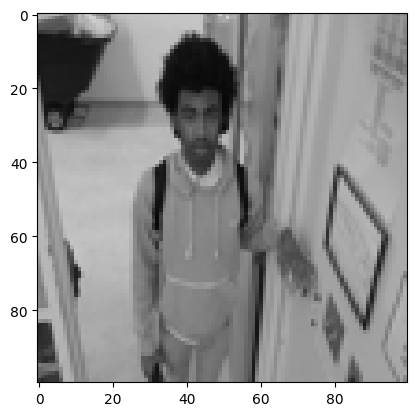

In [ ]:
# Print out the first prediction. Look at the result visually: did it work?
pred[0], prob[0], test_labels[0], student_names[test_labels[0]]

plt.imshow(test_inputs[0])
plt.show()

10 13 0.897456 4 Destin_Jack Kaci_Turner


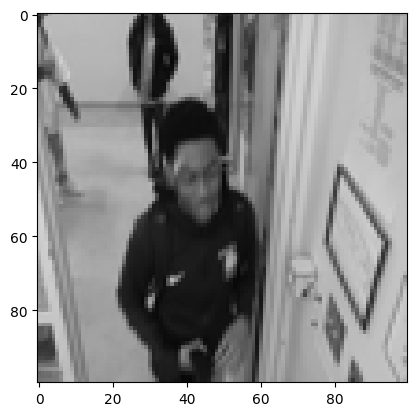

16 15 0.37377807 4 Destin_Jack Cordarius_Williams


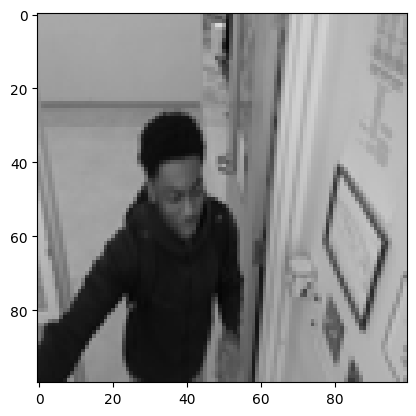

27 9 0.99999774 6 Lucian_Leon Julian_Carlson


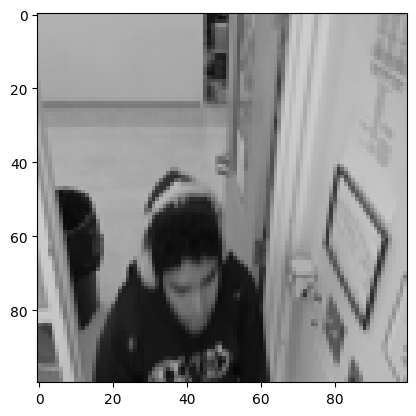

29 29 0.57734597 6 Lucian_Leon Tarrence_Sturdivant


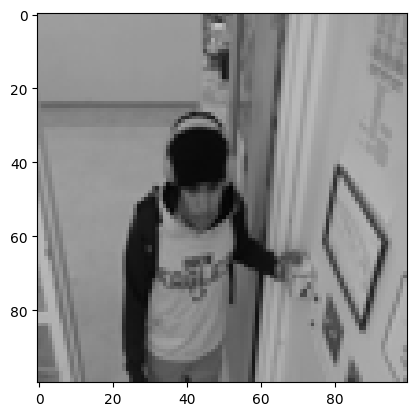

33 34 0.97159 7 Jonathan_Thompson Landon_Cox


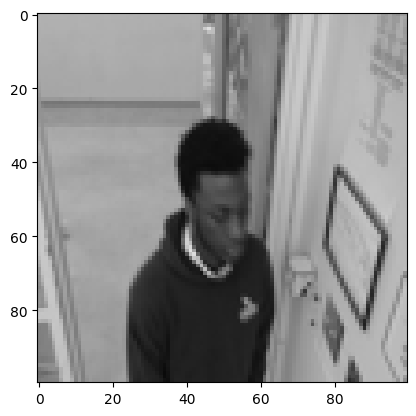

40 18 0.99951196 9 Julian_Carlson Peter_McKnight


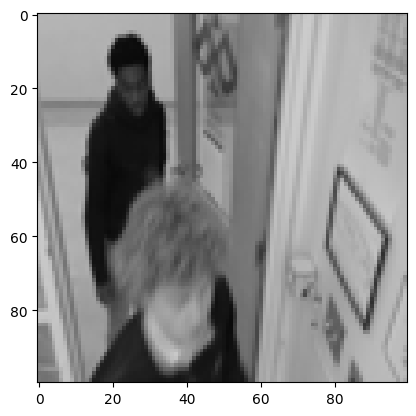

42 12 0.8906372 9 Julian_Carlson Malik_Weems


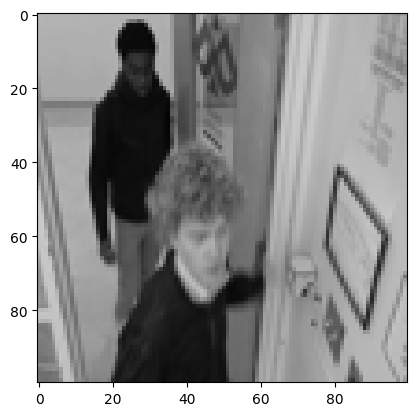

83 16 0.8067547 15 Cordarius_Williams Tunazi_Bello


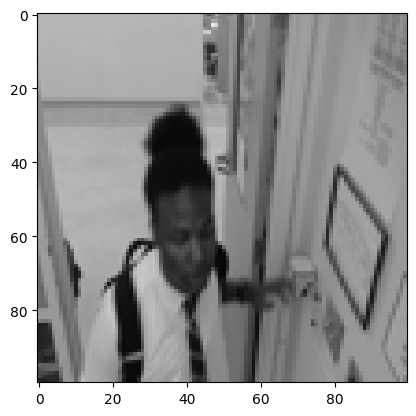

85 1 0.59414566 15 Cordarius_Williams Chase_Griffin


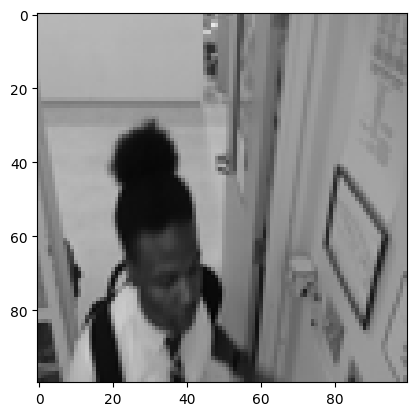

96 18 0.8413329 19 Zediwa_De Jesus Peter_McKnight


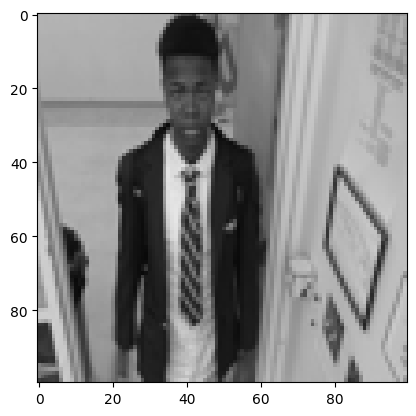

97 23 0.9349015 19 Zediwa_De Jesus Eric_Ayers


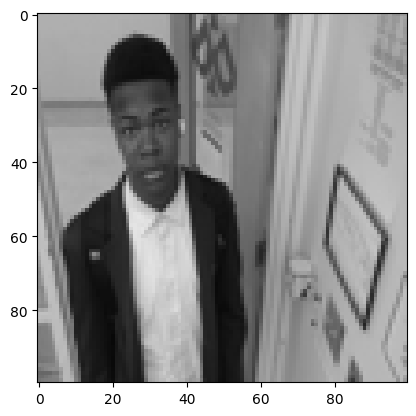

104 15 0.98548895 20 Justin_Brown Cordarius_Williams


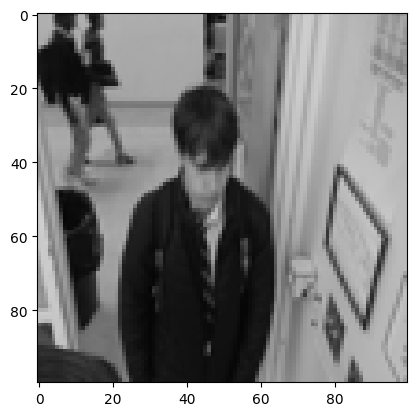

106 19 0.990239 20 Justin_Brown Zediwa_De Jesus


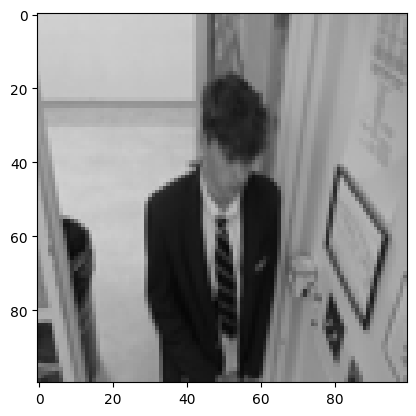

110 11 0.42668134 20 Justin_Brown Destin_Woolf


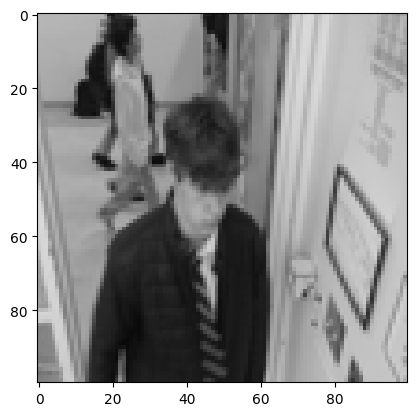

131 24 0.7753757 23 Eric_Ayers Curtis_Augustin


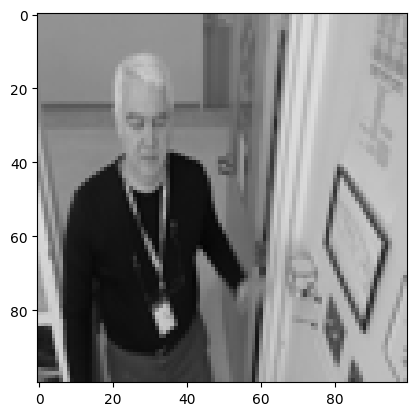

152 29 0.9993278 26 Rhyland_O'Neill Tarrence_Sturdivant


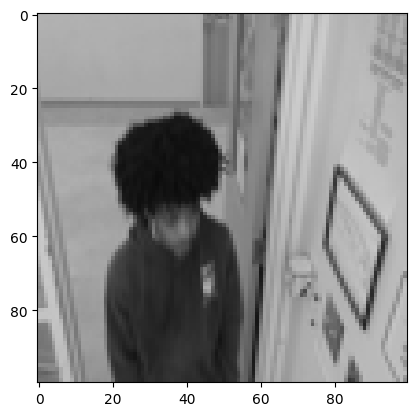

157 28 0.6963532 27 Justin_Leake Jackson_Humphries


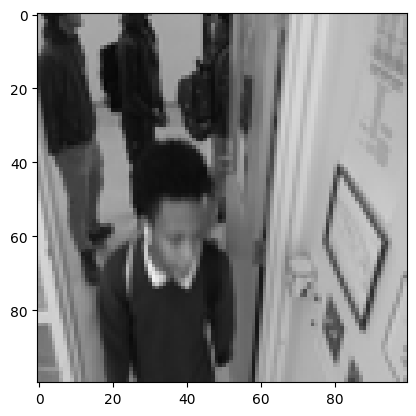

161 21 0.99797887 28 Jackson_Humphries Alexandra_Price


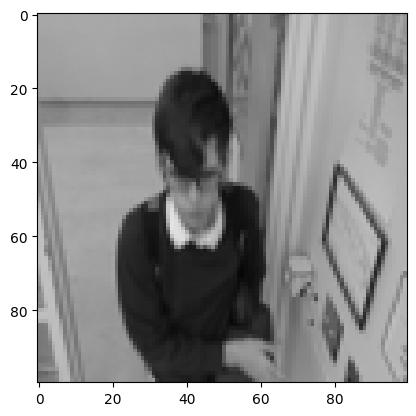

164 9 0.7929013 28 Jackson_Humphries Julian_Carlson


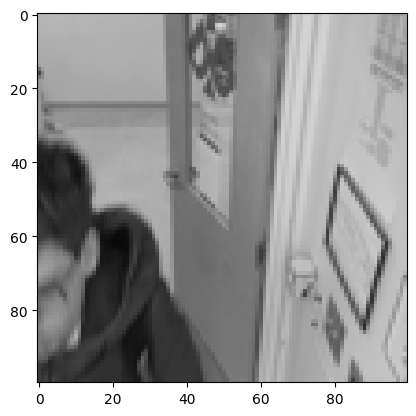

168 29 0.7345277 28 Jackson_Humphries Tarrence_Sturdivant


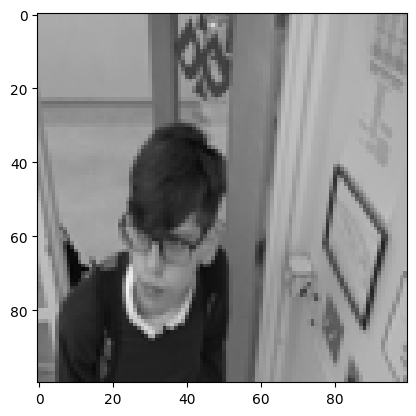

170 6 0.6152368 29 Tarrence_Sturdivant Lucian_Leon


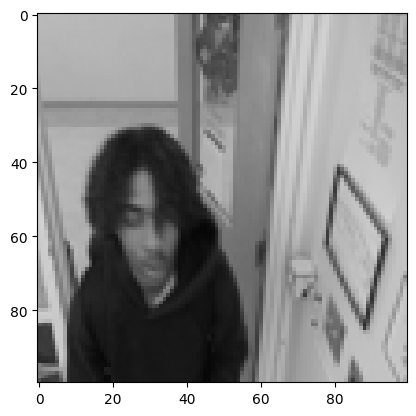

175 9 0.999882 29 Tarrence_Sturdivant Julian_Carlson


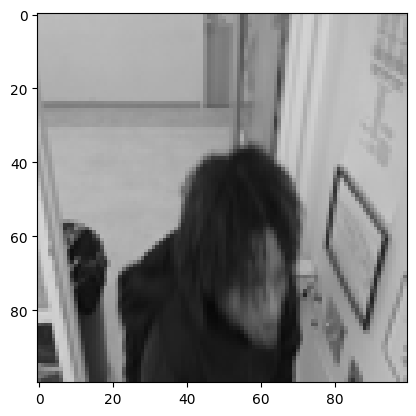

188 19 0.9500433 33 Emma_Davis Zediwa_De Jesus


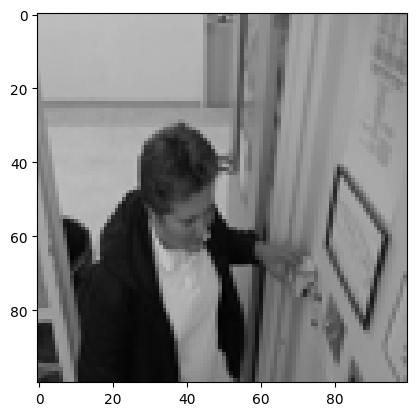

In [ ]:
for k in range(len(test_inputs)):
    if pred[k] != test_labels[k]:
        print(k,pred[k], prob[k], test_labels[k], student_names[test_labels[k]],student_names[pred[k]])
        plt.imshow(test_inputs[k])
        plt.show()

Less than 90 percent confidence in 24 of 195
Showing results with less than 60^ confidence:
16 15 0.37377807 4 Destin_Jack Cordarius_Williams


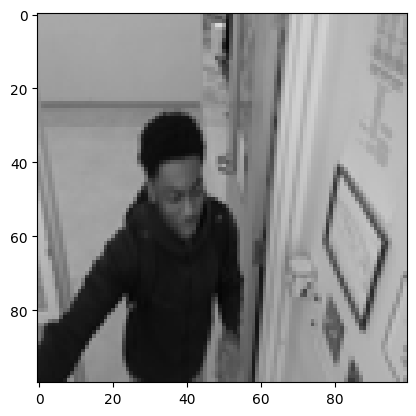

29 29 0.57734597 6 Lucian_Leon Tarrence_Sturdivant


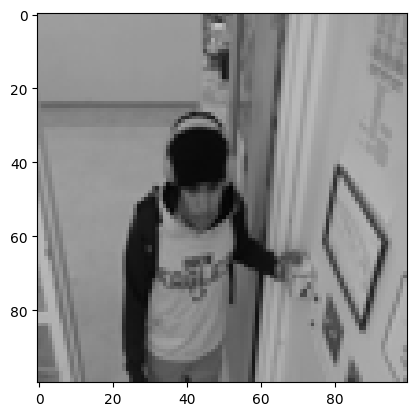

47 10 0.57195574 10 Laila_Shannon Laila_Shannon


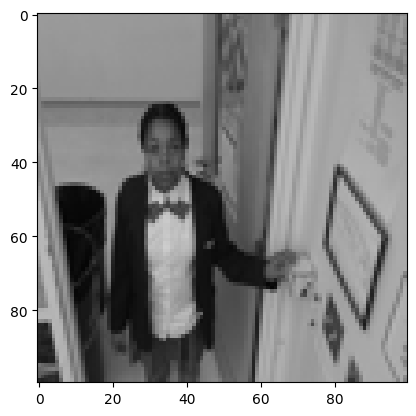

75 15 0.49922314 15 Cordarius_Williams Cordarius_Williams


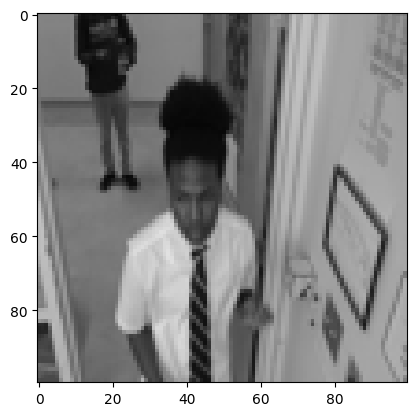

85 1 0.59414566 15 Cordarius_Williams Chase_Griffin


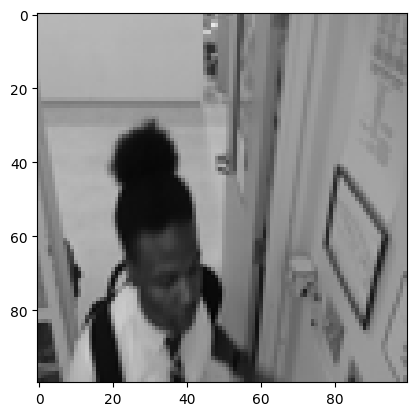

105 20 0.50261414 20 Justin_Brown Justin_Brown


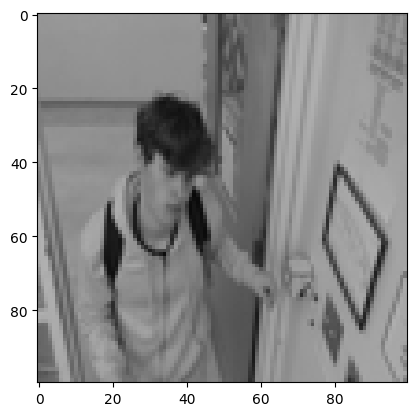

110 11 0.42668134 20 Justin_Brown Destin_Woolf


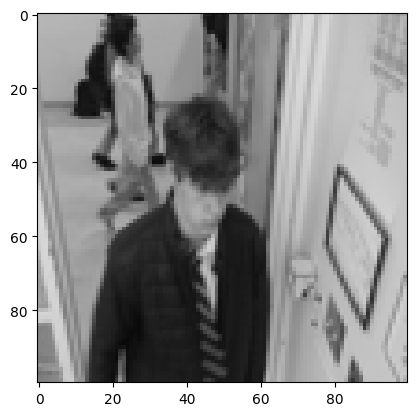

145 25 0.4046012 25 Kenadie_Smith Kenadie_Smith


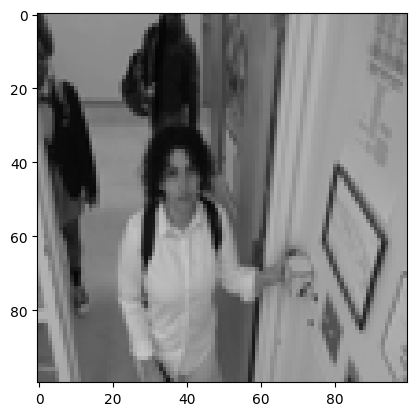

In [ ]:
# Judge the quality of the predicitons in the set of test images
uncertain_count = 0
for k in range(len(test_inputs)):
    if prob[k] <= 0.9:
        uncertain_count = uncertain_count + 1

print("Less than 90 percent confidence in %d of %d" % (uncertain_count, len(test_inputs)))

print("Showing results with less than 60^ confidence:")
for k in range(len(test_inputs)):
    if prob[k] <= .6:
        print(k,pred[k], prob[k], test_labels[k], student_names[test_labels[k]],student_names[pred[k]])
        plt.imshow(test_inputs[k])
        plt.show()
